This project uses synthetic generated data from https://infinity.ai/ \
Github https://github.com/toinfinityai/infinity-datasets/tree/main 


#### Parameters
num_reps:  Number of exercise repetitions in the returned time series data.\
watch_location:  Wrist where device is placed (left or right).\
crown_orientation:  Which side the watch crown points (from first-person perspective; left or right).\
ref_xy_rotation:  Rotation (in XY plane) of the reference orientation in radians (simulates the xArbitraryZVertical reference in the Apple CoreMotion SDK).\
rel_baseline_speed:  Baseline speed of animation, relative to default (natural) speed.\
max_rel_speed_change:  Maximum speed change introduced, relative to baseline speed.\
trim_start_frac:  Fraction of seed animation (from start to midpoint) to truncate at the start.\
trim_end_frac:  Fraction of seed animation (from start to midpoint) to truncate at the end.\
kinematic_noise_factor:  Scaling factor used to adjust the amount of kinematic noise added in the simulated movement.\
wrist_offset_deg:  Fixed rotation offset applied to the supination/pronation axis of the wrists, in degrees. Negative values correspond to supination.\
randomize_body_shape:  If True, the avatar's body shape is randomized.\
frames_per_second:  Sampling rate of exported time series and video.\
image_width:  Width dimension of the rendered video, in pixels.\
image_height:  Height dimension of the rendered video, in pixels.


In [18]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None) 
#pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')

In [1]:
#function for retrieving multiple csv/json files

import glob
import pandas as pd
import json
from pandas import json_normalize
import os
import numpy as np

def create_combined_dataframe(directory):
    """
    Create a combined DataFrame for each set of CSV and JSON files in the specified directory.

    Parameters:
    - directory (str): The directory containing CSV and JSON files.

    Returns:
    - List[pd.DataFrame]: A list of DataFrames where each DataFrame combines CSV and JSON data, with each parameter in the JSON file having its own column.
    """
    combined_dfs = []
    
    # creates list of file names matching the pattern '*.csv' in the specified directory
    csv_files = glob.glob(f'{directory}/*.csv')

    # Process each CSV file
    for csv_file in csv_files:
        csv_df = pd.read_csv(csv_file, index_col=0)

        # json file path
        json_file = os.path.splitext(csv_file)[0] + '_params.json'

        # Read and normalize json file, create df
        with open(json_file, 'r') as f:
            json_data = json.load(f)

        json_df = json_normalize(json_data)
        json_df.columns = [col.replace('params.', '') for col in json_df.columns]
        json_df = pd.concat([json_df] * len(csv_df), ignore_index=True)

        #combined data frames
        combined_df = pd.concat([json_df, csv_df], axis=1)
        combined_dfs.append(combined_df)

    return combined_dfs

In [2]:
#creating list of armraise dataframes
armraise_path = '../data/basic_motions/armraise'
armraise_dataframes = create_combined_dataframe(armraise_path)

In [3]:
armraise_dataframes[0]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,time,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.00,0.313452,-0.218860,-0.924039,0.097586,0.975350,-0.197910,0.944576,-0.028138,0.327084
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.05,0.319075,-0.216120,-0.922758,0.092488,0.976105,-0.196634,0.943206,-0.022603,0.331439
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.10,0.331619,-0.214452,-0.918716,0.085394,0.976647,-0.197151,0.939541,-0.013074,0.342188
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.15,0.350453,-0.213280,-0.911973,0.077130,0.976991,-0.198847,0.933399,-0.000654,0.358839
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,0.20,0.379883,-0.213341,-0.900097,0.067529,0.976841,-0.203030,0.922566,0.016345,0.385492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,35.45,0.515902,-0.055648,-0.854838,-0.001645,0.997822,-0.065948,0.856646,0.035429,0.514687
710,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,35.50,0.458979,-0.059240,-0.886470,0.014939,0.998148,-0.058968,0.888321,0.013822,0.459014
711,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,35.55,0.416546,-0.063375,-0.906903,0.030470,0.997980,-0.055744,0.908604,-0.004413,0.417636
712,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,...,35.60,0.383611,-0.067923,-0.920994,0.048168,0.997406,-0.053496,0.922238,-0.023840,0.385887


In [4]:
armraise_dataframes[0]['watch_location'].unique()

array(['RIGHT'], dtype=object)

In [5]:
armraise_dataframes[0]['crown_orientation'].unique()

array(['LEFT'], dtype=object)

In [6]:
#setting up the rest of the dataframes
bicepcurl_path = '../data/basic_motions/bicepcurl'
bicepcurl_dataframes = create_combined_dataframe(bicepcurl_path)

birddog_path = '../data/basic_motions/birddog'
birddog_dataframes = create_combined_dataframe(birddog_path)

burpee_path = '../data/basic_motions/burpee'
burpee_dataframes = create_combined_dataframe(burpee_path)

crunch_path = '../data/basic_motions/crunch'
crunch_dataframes = create_combined_dataframe(crunch_path)

hammercurl_path = '../data/basic_motions/hammercurl'
hammercurl_dataframes = create_combined_dataframe(hammercurl_path)

overheadpress_path = '../data/basic_motions/overheadpress'
overheadpress_dataframes = create_combined_dataframe(overheadpress_path)

pushup_path = '../data/basic_motions/pushup'
pushup_dataframes = create_combined_dataframe(pushup_path)

tricepkickback_left_path = '../data/basic_motions/tricepkickback_left'
tricepkickback_left_dataframes = create_combined_dataframe(tricepkickback_left_path)

tricepkickback_right_path = '../data/basic_motions/tricepkickback_right'
tricepkickback_right_dataframes = create_combined_dataframe(tricepkickback_right_path)

vup_path = '../data/basic_motions/vup'
vup_dataframes = create_combined_dataframe(vup_path)

In [7]:
birddog_dataframes[0]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,time,rotation_matrix_m11,rotation_matrix_m12,rotation_matrix_m13,rotation_matrix_m21,rotation_matrix_m22,rotation_matrix_m23,rotation_matrix_m31,rotation_matrix_m32,rotation_matrix_m33
0,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,0.00,-0.037622,0.106578,-0.993593,0.122555,-0.986299,-0.110436,-0.991749,-0.125924,0.024044
1,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,0.05,-0.036055,0.107612,-0.993539,0.087344,-0.990041,-0.110403,-0.995525,-0.090761,0.026297
2,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,0.10,-0.033051,0.109509,-0.993436,0.056639,-0.992177,-0.111254,-0.997848,-0.059944,0.026590
3,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,0.15,-0.028934,0.112682,-0.993210,0.030471,-0.993064,-0.113553,-0.999117,-0.033550,0.025300
4,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,0.20,-0.023400,0.116408,-0.992926,0.012832,-0.993081,-0.116729,-0.999644,-0.015473,0.021744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3058,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,152.90,0.042978,0.182746,-0.982220,-0.195357,-0.962613,-0.187646,-0.979790,0.199949,-0.005671
3059,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,152.95,0.035351,0.180825,-0.982880,-0.206670,-0.960912,-0.184217,-0.977772,0.209644,0.003402
3060,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,153.00,0.030335,0.178732,-0.983430,-0.222507,-0.957987,-0.180972,-0.974459,0.224310,0.010708
3061,BIRD_DOG,15,LEFT,RIGHT,1.377777,0.813707,0.142183,0.0,0.0,1.458842,...,153.05,0.026874,0.176068,-0.984011,-0.241001,-0.954190,-0.177314,-0.970153,0.241913,0.016790


## Learning about changing rotational transformation matrix to roll-pitch-yaw

There are many csv's to import, but I am just looking at one exercise right now while I learn about converting a rotational matrix to roll-pitch-yaw. I will import the rest afterwards.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_euler.html \
https://eigen.tuxfamily.org/dox/group__Geometry__Module.html#title40 \
https://github.com/zivid/zivid-python-samples/blob/master/source/applications/advanced/hand_eye_calibration/pose_conversions.py 

In [8]:
#fuction to convert the rotation matrix to euler angles

import pandas as pd
from scipy.spatial.transform import Rotation as R

def add_euler_columns(df):
    rotation_matrix_columns = [
        'rotation_matrix_m11', 'rotation_matrix_m12', 'rotation_matrix_m13',
        'rotation_matrix_m21', 'rotation_matrix_m22', 'rotation_matrix_m23',
        'rotation_matrix_m31', 'rotation_matrix_m32', 'rotation_matrix_m33'
    ]

    rotation_matrices = df[rotation_matrix_columns].values.reshape(-1, 3, 3)
    euler_angles = R.from_matrix(rotation_matrices).as_euler("xyz")

    euler_df = pd.DataFrame(euler_angles, columns=['euler_x', 'euler_y', 'euler_z'])
    
    
    df = df.drop(rotation_matrix_columns, axis=1)
    df = pd.concat([df, euler_df], axis=1)

    return df

In [9]:
# Update each DataFrame in the list with euler angles instead of rotation matrix
for i in range(len(armraise_dataframes)):
    armraise_dataframes[i] = add_euler_columns(armraise_dataframes[i])


In [10]:
armraise_dataframes[50]

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,...,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,euler_x,euler_y,euler_z
0,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,0.466667,0.000000,0.879822,0.00,-1.128989,0.313235,1.891659
1,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,0.492401,0.025734,0.879822,0.05,-1.060150,0.327630,1.943922
2,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,0.518163,0.051496,0.879822,0.10,-0.968391,0.333875,2.012972
3,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,0.543954,0.077288,0.879822,0.15,-0.885528,0.322451,2.076853
4,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,0.569774,0.103108,0.879822,0.20,-0.782802,0.293343,2.155573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,10.307658,9.840991,0.879822,18.55,-0.499118,0.155347,2.207591
372,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,10.333505,9.866838,0.879822,18.60,-0.620559,0.225231,2.133814
373,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,10.359340,9.892673,0.879822,18.65,-0.744739,0.279013,2.056999
374,ARM_RAISE-DUMBBELL,10,LEFT,RIGHT,0.879822,1.059816,0.032639,0.103032,0.156034,0.826002,...,1984524181,1.0,100,10.385163,9.918496,0.879822,18.70,-0.839479,0.310311,1.999223


In [11]:
# Update each DataFrame in the list with euler angles instead of rotation matrix

for i in range(len(bicepcurl_dataframes)):
    bicepcurl_dataframes[i] = add_euler_columns(bicepcurl_dataframes[i])
    
for i in range(len(birddog_dataframes)):
    birddog_dataframes[i] = add_euler_columns(birddog_dataframes[i])
    
for i in range(len(burpee_dataframes)):
    burpee_dataframes[i] = add_euler_columns(burpee_dataframes[i])

for i in range(len(crunch_dataframes)):
    crunch_dataframes[i] = add_euler_columns(crunch_dataframes[i])
    
for i in range(len(hammercurl_dataframes)):
    hammercurl_dataframes[i] = add_euler_columns(hammercurl_dataframes[i])
    
for i in range(len(overheadpress_dataframes)):
    overheadpress_dataframes[i] = add_euler_columns(overheadpress_dataframes[i])
    
for i in range(len(pushup_dataframes)):
    pushup_dataframes[i] = add_euler_columns(pushup_dataframes[i])
    
for i in range(len(tricepkickback_left_dataframes)):
    tricepkickback_left_dataframes[i] = add_euler_columns(tricepkickback_left_dataframes[i])
    
for i in range(len(tricepkickback_right_dataframes)):
    tricepkickback_right_dataframes[i] = add_euler_columns(tricepkickback_right_dataframes[i])
    
for i in range(len(vup_dataframes)):
    vup_dataframes[i] = add_euler_columns(vup_dataframes[i])


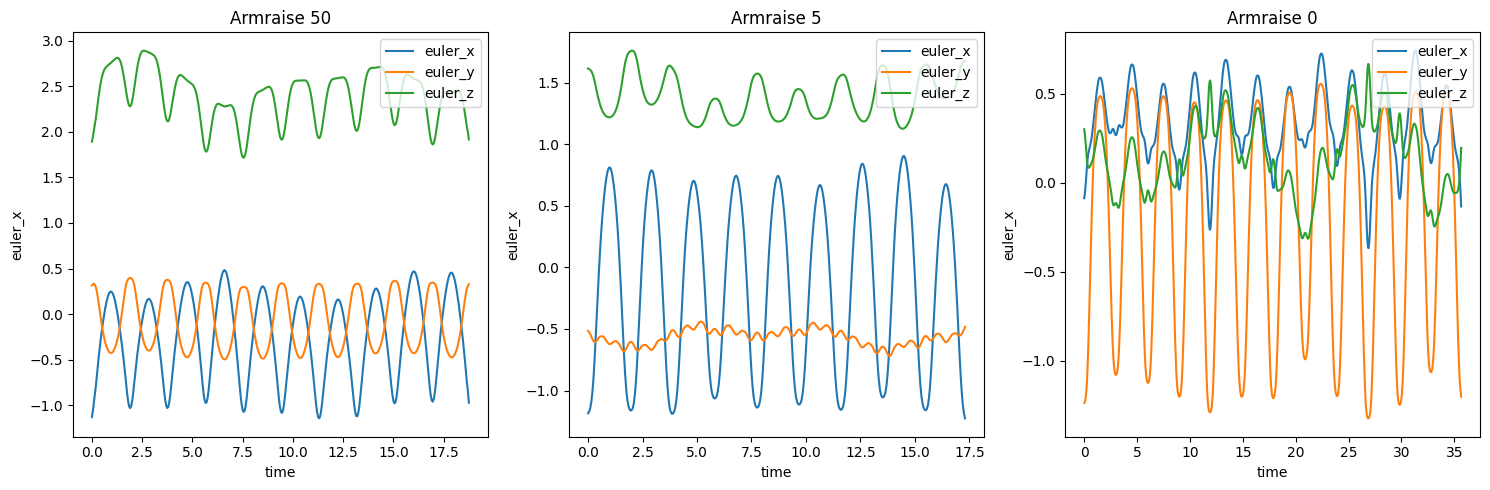

In [15]:
#plotting euler angles armraises

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=armraise_dataframes[50], x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Armraise 50')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=armraise_dataframes[5], x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Armraise 5')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=armraise_dataframes[0], x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Armraise 0')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()


In [16]:
# scales are different at this time, can I scale these?

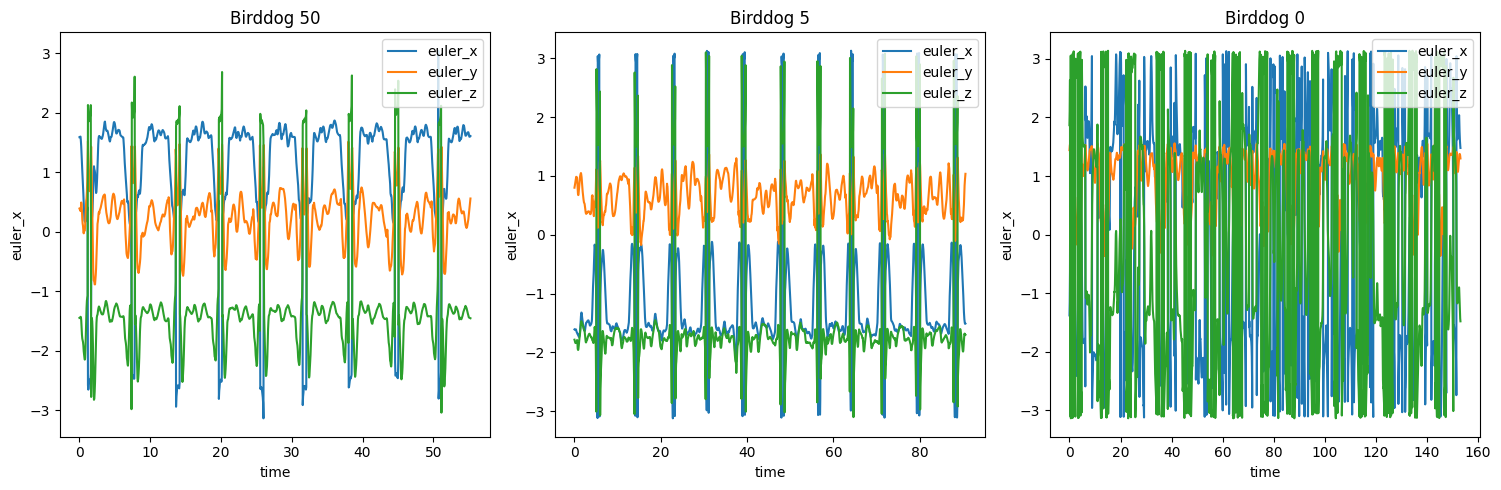

In [17]:
#plotting euler angles birddog

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot for armraise_dataframes[50]
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_x", label="euler_x", ax=axes[0])
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_y", label="euler_y", ax=axes[0])
sns.lineplot(data=birddog_dataframes[50], x="time", y="euler_z", label="euler_z", ax=axes[0])
axes[0].set_title('Birddog 50')
axes[0].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[5]
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_x", label="euler_x", ax=axes[1])
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_y", label="euler_y", ax=axes[1])
sns.lineplot(data=birddog_dataframes[5], x="time", y="euler_z", label="euler_z", ax=axes[1])
axes[1].set_title('Birddog 5')
axes[1].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

# Plot for armraise_dataframes[0]
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_x", label="euler_x", ax=axes[2])
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_y", label="euler_y", ax=axes[2])
sns.lineplot(data=birddog_dataframes[0], x="time", y="euler_z", label="euler_z", ax=axes[2])
axes[2].set_title('Birddog 0')
axes[2].legend(loc='upper right', bbox_to_anchor=(1, 1))  # Adjust the bbox_to_anchor

plt.tight_layout()
plt.show()

## Learning about Fourier Transform

https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/ \
https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101

In [20]:
import pandas as pd
import numpy as np
from scipy.fft import fft

df2 = armraise_dataframes[0]

euler_columns = ['euler_x', 'euler_y', 'euler_z']

# Apply Fourier transform to each column
for col in euler_columns:
    euler_array = np.ascontiguousarray(df2[col].values)
    
    df2[f'{col}_fft'] = np.abs(fft(euler_array))


In [21]:
df2

,exercise,num_reps,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,trim_start_frac,trim_end_frac,kinematic_noise_factor,wrist_offset_deg,use_random_motion,randomize_body_shape,frames_per_second,image_width,image_height,random_seed,seconds_per_rep,num_random_frames,rep_count_from_intermediate,rep_count_from_start,ref_xy_rotation,time,euler_x,euler_y,euler_z,euler_x_fft,euler_y_fft,euler_z_fft
0,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.473684,0.000000,4.818261,0.00,-0.085816,-1.236302,0.301816,233.448722,164.943182,104.794592
1,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.490279,0.016595,4.818261,0.05,-0.068092,-1.232152,0.282132,0.427206,5.311859,17.004060
2,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.506874,0.033190,4.818261,0.10,-0.038189,-1.221286,0.252032,11.860372,21.937540,60.676702
3,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.523469,0.049785,4.818261,0.15,-0.001822,-1.203772,0.216632,0.547906,14.878555,56.158340
4,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,0.540063,0.066379,4.818261,0.20,0.042375,-1.174680,0.175925,28.460837,16.318868,17.178685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.370983,11.897299,4.818261,35.45,0.068727,-1.028733,-0.003188,13.197612,1.616661,10.294815
710,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.387749,11.914065,4.818261,35.50,0.030103,-1.093677,0.032537,28.460837,16.318868,17.178685
711,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.404509,11.930825,4.818261,35.55,-0.010567,-1.139929,0.073019,0.547906,14.878555,56.158340
712,ARM_RAISE-DUMBBELL,12,RIGHT,LEFT,4.818261,0.851037,0.024017,0.045082,0.057994,0.980721,9.201472,False,True,20,480,480,677412957,1.0,100,12.421261,11.947576,4.818261,35.60,-0.061702,-1.173829,0.124910,11.860372,21.937540,60.676702


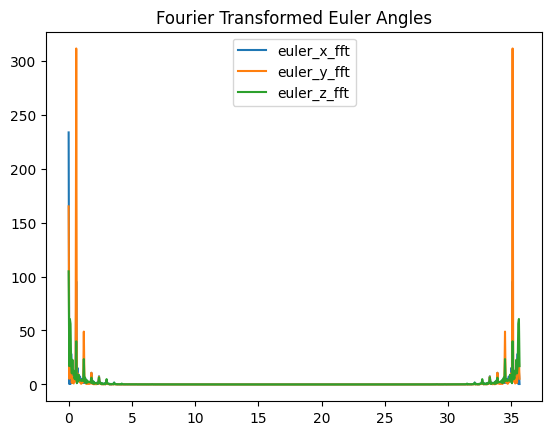

In [37]:
import matplotlib.pyplot as plt

# Assuming df2 is your DataFrame with Fourier-transformed columns
euler_fft_columns = ['euler_x_fft', 'euler_y_fft', 'euler_z_fft']

# Plot each Fourier-transformed column
for col in euler_fft_columns:
    plt.plot(df2['time'], df2[col], label=col)

plt.legend()
plt.title('Fourier Transformed Euler Angles')

# Show the plot
plt.show()

.